In [ ]:
# 1. IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.datasets import fetch_california_housing, make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression, Ridge, Lasso,
RidgeCV, LassoCV, Perceptron)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score


# plotting defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)


# reproducibility
RNG = 42
np.random.seed(RNG)

In [ ]:
# 2. LOAD DATA
data = fetch_california_housing(as_frame=True)
df = data.frame.copy()


print('Shape:', df.shape)
df.head()

Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
# 3. PREPARE FEATURES AND TARGET
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']
feature_names = X.columns.tolist()


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
X_scaled, y, test_size=0.20, random_state=RNG
)


print('Train shape:', X_train.shape)
print('Test shape :', X_test.shape)

Train shape: (16512, 8)
Test shape : (4128, 8)


In [ ]:
# 4. LINEAR REGRESSION (baseline)
lr = LinearRegression()
lr.fit(X_train, y_train)


y_pred_lr = lr.predict(X_test)


print('Linear Regression:')
print(' R^2 :', r2_score(y_test, y_pred_lr))
print(' RMSE :', np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression:
 R^2 : 0.5757877060324511
 RMSE : 0.7455813830127761


In [ ]:
# 5. RIDGE & LASSO with chosen alphas
ridge = Ridge(alpha=10.0, random_state=RNG)
ridge.fit(X_train, y_train)


lasso = Lasso(alpha=0.1, max_iter=5000, random_state=RNG)
lasso.fit(X_train, y_train)


y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)


print('Ridge (alpha=10) R^2:', r2_score(y_test, y_pred_ridge), ' RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print('Lasso (alpha=0.1) R^2:', r2_score(y_test, y_pred_lasso), ' RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Ridge (alpha=10) R^2: 0.5760870567061362  RMSE: 0.7453182722064476
Lasso (alpha=0.1) R^2: 0.4814202815313765  RMSE: 0.824349148731848


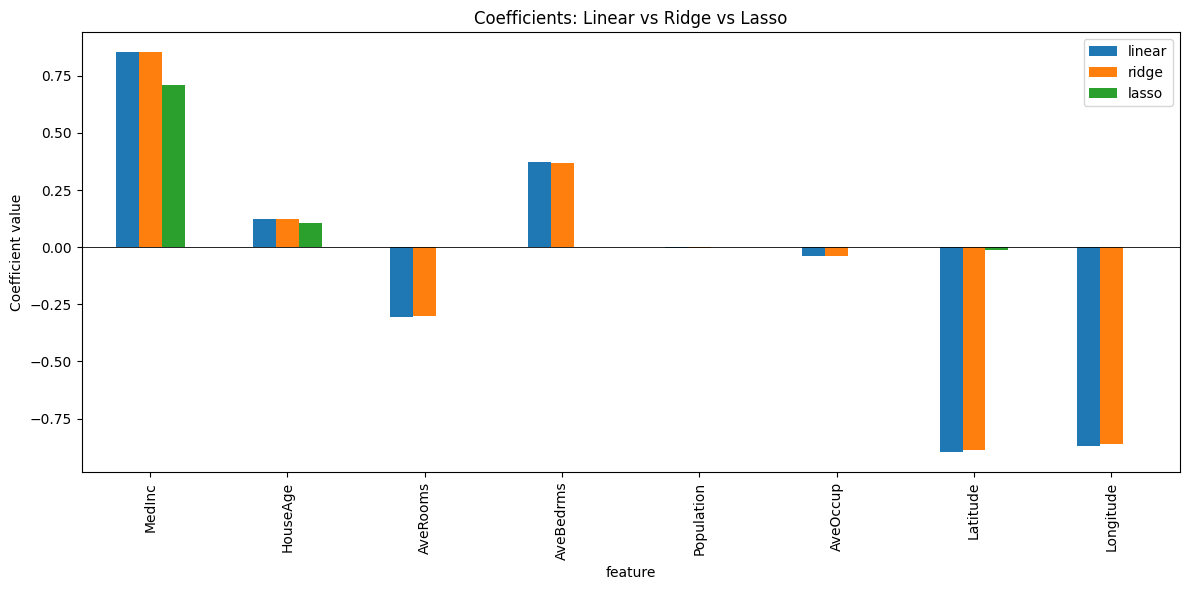

In [ ]:
coef_df = pd.DataFrame({
'feature': feature_names,
'linear': lr.coef_,
'ridge': ridge.coef_,
'lasso': lasso.coef_
})


coef_df = coef_df.set_index('feature')
coef_df


# Plot comparison
coef_df.plot(kind='bar', figsize=(12,6))
plt.axhline(0, color='k', linewidth=0.6)
plt.title('Coefficients: Linear vs Ridge vs Lasso')
plt.ylabel('Coefficient value')
plt.tight_layout()
plt.show()

In [ ]:
# 7. CROSS-VALIDATION FOR ALPHA
alphas_ridge = np.logspace(-3, 3, 50)
alphas_lasso = np.logspace(-4, 1, 50)


ridge_cv = RidgeCV(alphas=alphas_ridge, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)


lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, max_iter=5000, random_state=RNG)
lasso_cv.fit(X_train, y_train)


print('Best Ridge alpha:', ridge_cv.alpha_)
print('Best Lasso alpha:', lasso_cv.alpha_)


# Refit final models with best alpha
ridge_best = Ridge(alpha=ridge_cv.alpha_).fit(X_train, y_train)
lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=5000).fit(X_train, y_train)


for name, model in [('Linear', lr), ('Ridge_CV', ridge_best), ('Lasso_CV', lasso_best)]:
  ypred = model.predict(X_test)
  print(f"{name}: R^2 = {r2_score(y_test, ypred):.4f}, RMSE = {np.sqrt(mean_squared_error(y_test, ypred)):.4f}")

Best Ridge alpha: 0.655128556859551
Best Lasso alpha: 0.0006551285568595509
Linear: R^2 = 0.5758, RMSE = 0.7456
Ridge_CV: R^2 = 0.5758, RMSE = 0.7456
Lasso_CV: R^2 = 0.5765, RMSE = 0.7449


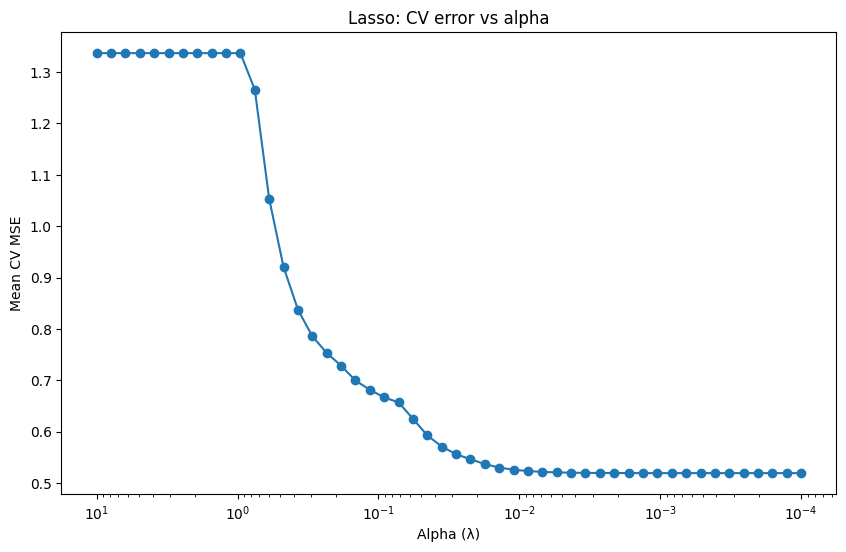

In [ ]:
# LassoCV exposes mse_path_ with shape (n_alphas, n_folds)
mse_mean = np.mean(lasso_cv.mse_path_, axis=1)
plt.semilogx(lasso_cv.alphas_, mse_mean, marker='o')
plt.xlabel('Alpha (λ)')
plt.ylabel('Mean CV MSE')
plt.title('Lasso: CV error vs alpha')
plt.gca().invert_xaxis() # alpha grid often stored decreasing; optional
plt.show()

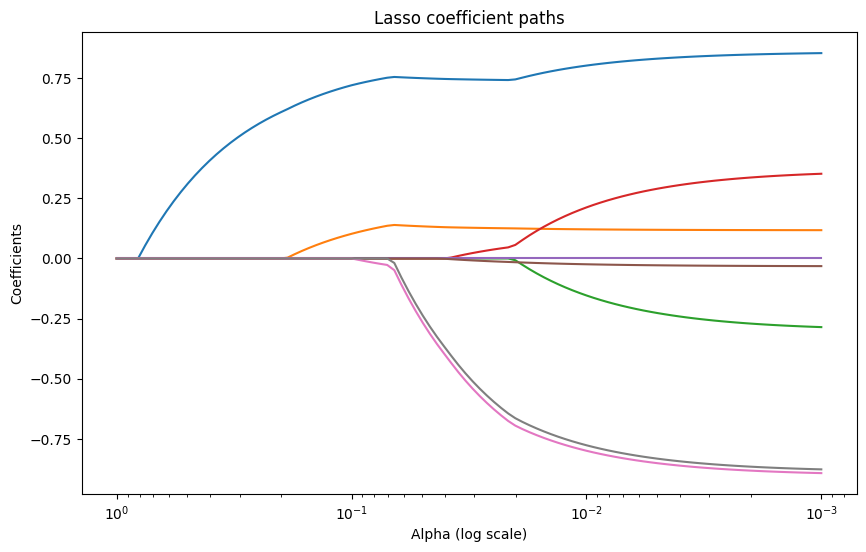

In [ ]:
from sklearn.linear_model import lasso_path


alphas_path, coefs_path, _ = lasso_path(X_train, y_train, alphas=np.logspace(-3, 0, 100))


plt.plot(alphas_path, coefs_path.T)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficients')
plt.title('Lasso coefficient paths')
plt.show()

Perceptron training accuracy: 0.8833333333333333


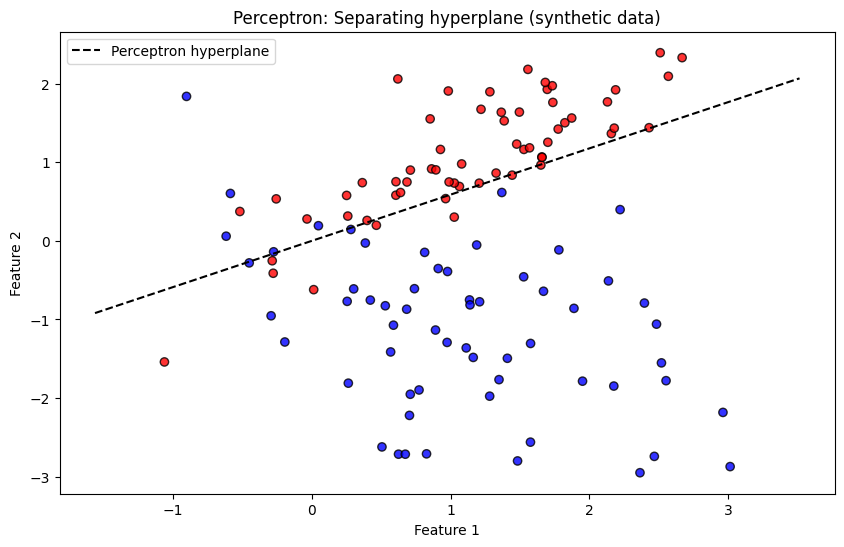

In [ ]:
# 9. PERCEPTRON DEMO
X_class, y_class = make_classification(
n_samples=120, n_features=2, n_redundant=0, n_clusters_per_class=1,
class_sep=1.2, random_state=RNG
)


# Train perceptron
perc = Perceptron(max_iter=1000, random_state=RNG)
perc.fit(X_class, y_class)


# Predictions & accuracy
y_pred_class = perc.predict(X_class)
print('Perceptron training accuracy:', accuracy_score(y_class, y_pred_class))


# Plot data and separating hyperplane
plt.scatter(X_class[:,0], X_class[:,1], c=y_class, cmap='bwr', edgecolor='k', alpha=0.8)


# extract a line: w0*x + w1*y + b = 0 => y = -(w0*x + b)/w1
w = perc.coef_[0]
b = perc.intercept_[0]


x_vals = np.linspace(X_class[:,0].min()-0.5, X_class[:,0].max()+0.5, 200)


if np.abs(w[1]) > 1e-8:
  y_vals = -(w[0]*x_vals + b) / w[1]
  plt.plot(x_vals, y_vals, 'k--', label='Perceptron hyperplane')
else:
  # Vertical line
  x_const = -b / w[0]
  plt.axvline(x_const, linestyle='--', color='k', label='Perceptron hyperplane')


plt.legend()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Perceptron: Separating hyperplane (synthetic data)')
plt.show()